# Glassdoor Web Scraping Job Data

In [2]:
import time
import re
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

In [ ]:
# --- Config ---
MAX_PAGE_CLICKS = 50
WAIT_TIME = 3
urls = [
    "https://www.glassdoor.com/Job/software-engineer-jobs-SRCH_KO0,17.htm",
    "https://www.glassdoor.com/Job/software-developer-jobs-SRCH_KO0,18.htm",
    "https://www.glassdoor.com/Job/data-analyst-jobs-SRCH_KO0,12.htm",
]

job_data = []
seen_jobs = set()  # Avoid duplicates

# --- Setup Stealth Driver ---
options = uc.ChromeOptions()
options.add_argument("--no-sandbox")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-extensions")
options.add_argument("--disable-gpu")
options.add_argument("--start-maximized")
options.add_argument("--disable-dev-shm-usage")
driver = uc.Chrome(options=options)
driver.execute_cdp_cmd("Network.setUserAgentOverride", {
    "userAgent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
})

# --- Helper Functions ---
def extract_rating(job_card):
    try:
        rating = job_card.find('span', class_='rating-single-star_RatingText__XENmU')
        return float(rating.text.strip()) if rating else None
    except:
        return None

def extract_salary(salary_text):
    return salary_text if salary_text else None

def scrape_page():
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    job_cards = soup.find_all('li', class_=lambda x: x and 'JobsList_jobListItem' in x)
    new_count = 0
    for job in job_cards:
        try:
            title = job.find('a', {'data-test': 'job-title'}).get_text(strip=True)
            company = job.find('div', class_='EmployerProfile_profileContainer__63w3R').get_text(strip=True)
            location = job.find('div', {'data-test': 'emp-location'}).get_text(strip=True)
            unique_key = f"{title}|{company}|{location}"
            if unique_key in seen_jobs:
                continue
            seen_jobs.add(unique_key)
            rating = extract_rating(job)
            salary_elem = job.find('div', {'data-test': 'detailSalary'})
            salary = extract_salary(salary_elem.get_text(strip=True)) if salary_elem else None
            is_remote = 'remote' in location.lower() or 'work from home' in location.lower()
            job_data.append([title, company, location, is_remote, rating, salary])
            new_count += 1
        except:
            continue
    print(f"Added {new_count} new jobs.")

def load_all_jobs():
    clicks = 0
    while clicks < MAX_PAGE_CLICKS:
        scrape_page()
        try:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)
            next_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(., 'Show more jobs')]"))
            )
            next_button.click()
            clicks += 1
            print(f"Clicked 'Show more jobs' ({clicks}/{MAX_PAGE_CLICKS})")
            time.sleep(WAIT_TIME)
        except Exception as e:
            print(f"No more jobs to show or error: {e}")
            break

# --- Run Scraper ---
print("Starting scraping...\n")
for url in urls:
    print(f"\nOpening: {url}")
    driver.get(url)
    time.sleep(5)
    load_all_jobs()

# --- Save and Display ---
df = pd.DataFrame(job_data, columns=['Title', 'Company', 'Location', 'Is_Remote', 'Rating', 'Salary'])
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Is_Remote'] = df['Is_Remote'].astype(bool)

print("\n✅ Scraping complete!")
print(f"🔢 Total unique jobs scraped: {len(df)}")



In [149]:
df.to_csv('D:/glassdoor_jobs.csv', index=False)

# Data Cleaning

In [150]:
import numpy as np

In [210]:
df = pd.read_csv("D:/glassdoor_jobs.csv")

In [211]:
df.head()

,Title,Company,Location,Is_Remote,Rating,Salary
0,Software Engineer I,ACT3.5,Remote,True,3.5,$70K - $85K(Employer est.)
1,Software Development Engineer III,American Express Global Business Travel4.1,"Bellevue, WA",False,4.1,$137K - $203K(Employer est.)
2,Software Development Engineer in Test,Industrial Scientific3.3,"Pittsburgh, PA",False,3.3,$62K - $116K(Employer est.)
3,Software Engineer 5- TV Client Foundations,Netflix4.2,Remote,True,4.2,$100K - $700K(Employer est.)
4,Steam Software Engineer,Valve Software4.6,"Bellevue, WA",False,4.6,$133K - $189K(Glassdoor est.)


In [212]:
df.isna().sum()

Title        0
Company      0
Location     0
Is_Remote    0
Rating       0
Salary       0
dtype: int64

In [213]:
# Handle missing ratings
df['Rating'] = df['Rating'].fillna("Not Rated")

# Handle missing salaries
df['Salary'] = df['Salary'].fillna("Not Disclosed")

# Verify changes
print("\nMissing values after cleaning:")
print(df.isna().sum())


Missing values after cleaning:
Title        0
Company      0
Location     0
Is_Remote    0
Rating       0
Salary       0
dtype: int64


### Duplicate Job Detection

In [176]:
# Find duplicates based on Company, Job Title, and Location
duplicates = df[df.duplicated(['Company', 'Title', 'Location'], keep=False)]

# Sort duplicates for easier viewing
duplicates_sorted = duplicates.sort_values(['Company', 'Title'])

# Show number of duplicate entries
print(f"Found {len(duplicates)} duplicate job titles within companies")
print(duplicates_sorted)

# Group duplicates to count repeated (Company, Job Title) combinations
dupe_summary = duplicates.groupby(['Company', 'Title', 'Location']).size().reset_index(name='count')

# Display only combinations that occur more than once
print("\nDuplicate summary:")
print(dupe_summary[dupe_summary['count'] > 1])


Found 0 duplicate job titles within companies
Empty DataFrame
Columns: [Title, Company, Location, Is_Remote, Rating, Salary]
Index: []

Duplicate summary:
Empty DataFrame
Columns: [Company, Title, Location, count]
Index: []


### Salary Cleaning

In [192]:
def extract_salary(salary_str):
    if pd.isna(salary_str):
        return np.nan, np.nan
    
    # Handle hourly rates
    if 'Per Hour' in salary_str:
        numbers = re.findall(r'\d+\.?\d*', salary_str)
        if len(numbers) >= 2:
            low = float(numbers[0]) * 2080  # Convert hourly to annual (2080 work hours/year)
            high = float(numbers[1]) * 2080
            return low, high
        elif len(numbers) == 1:
            val = float(numbers[0]) * 2080
            return val, val
    
    # Handle salary ranges
    numbers = re.findall(r'\d+\.?\d*', salary_str.replace(',', ''))
    if 'K' in salary_str:
        if len(numbers) >= 2:
            return float(numbers[0]) * 1000, float(numbers[1]) * 1000
        elif len(numbers) == 1:
            val = float(numbers[0]) * 1000
            return val, val
    else:
        if len(numbers) >= 2:
            return float(numbers[0]), float(numbers[1])
        elif len(numbers) == 1:
            val = float(numbers[0])
            return val, val
    
    return np.nan, np.nan

df[['salary_low', 'salary_high']] = df['Salary'].apply(
    lambda x: pd.Series(extract_salary(x)))
df['salary_avg'] = (df['salary_low'] + df['salary_high']) / 2

### Processing Job Title Into Experience

In [ ]:
def get_experience_level(title):
    title = str(title).lower()
    if 'junior' in title or 'entry' in title or 'i ' in title or 'associate' in title or '1' in title :
        return 'Entry'
    elif 'senior' in title or 'sr.' in title or 'iii' in title or '3' in title:
        return 'Senior'
    elif 'ii' in title or '2' in title or 'mid' in title:
        return 'Mid'
    else:
        return 'Not Specified'

df['experience_level'] = df['Title'].apply(get_experience_level)

### Categorizing Jobs

In [195]:
def extract_tech(title):
    title = str(title).lower()
    techs = []
    
    # Technology-related keywords (case-insensitive)
    if 'java' in title:
        techs.append('Java')
    if 'python' in title:
        techs.append('Python')
    if 'c++' in title:
        techs.append('C++')
    if 'dart' in title:
        techs.append('Dart')
    
    # Backend / Frontend / Full Stack
    if 'backend' in title:
        techs.append('Backend')
    if 'frontend' in title or 'front end' in title:
        techs.append('Frontend')
    if 'full stack' in title or 'full-stack' in title:
        techs.append('Full Stack')
    
    # Specialized areas
    if 'data' in title:
        techs.append('Data')
    if 'cloud' in title:
        techs.append('Cloud')
    
    # Catch-all for general or undefined roles
    if 'software engineer' in title:
        techs.append('Software Engineer')
    
    # If no specific technologies found, classify as 'Other'
    return ', '.join(techs) if techs else 'Other'



### Locations

In [196]:
# Clean location data
def clean_location(loc):
    # If the location is NaN or contains 'remote' or 'United States', categorize as 'Remote'
    if pd.isna(loc) or 'remote' in str(loc).lower() or 'united states' in str(loc).lower():
        return 'Remote'
    
    # Clean up the location (split by comma and take the first part as the main location)
    loc = str(loc).split(',')[0].strip()
    return loc

# Apply the clean_location function to the 'Location' column
df['clean_location'] = df['Location'].apply(clean_location)


# Visualization

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

### Salary Distribution

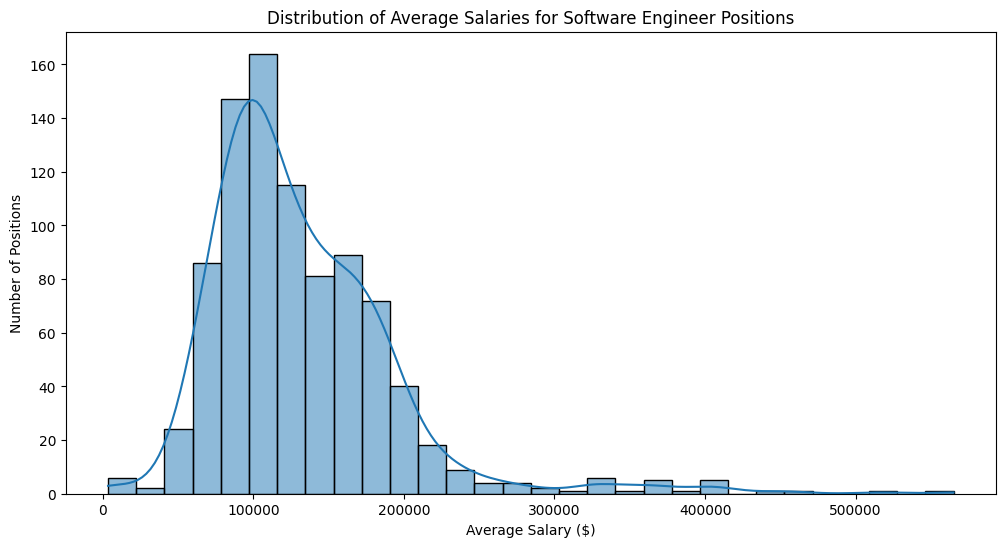

In [198]:
plt.figure(figsize=(12, 6))
sns.histplot(df['salary_avg'].dropna(), bins=30, kde=True)
plt.title('Distribution of Average Salaries for Software Engineer Positions')
plt.xlabel('Average Salary ($)')
plt.ylabel('Number of Positions')
plt.show()

### Salary By Experince Level


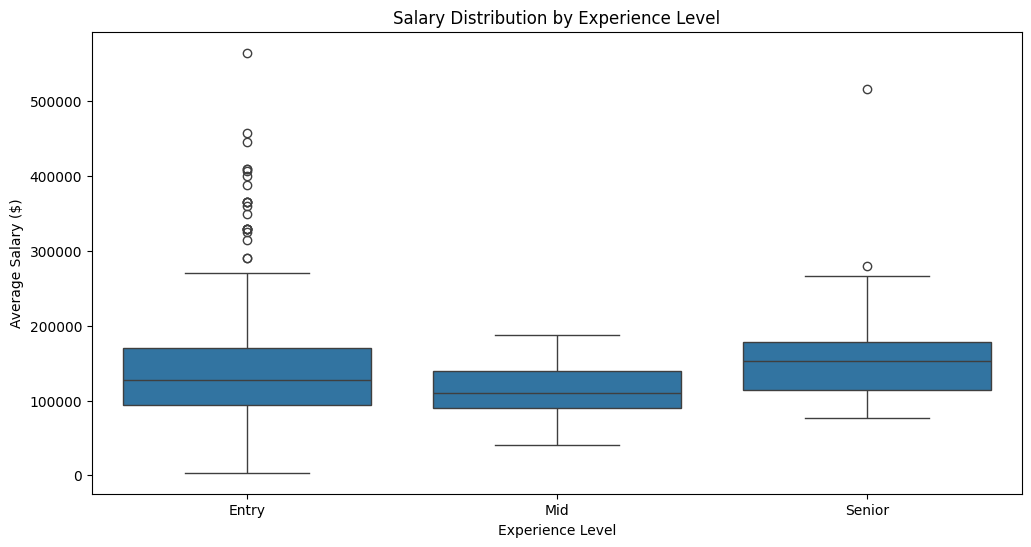

In [199]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='experience_level', y='salary_avg', data=df[df['experience_level'] != 'Not Specified'],
            order=['Entry', 'Mid', 'Senior'])
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Average Salary ($)')
plt.show()


### Top Hiring Companies

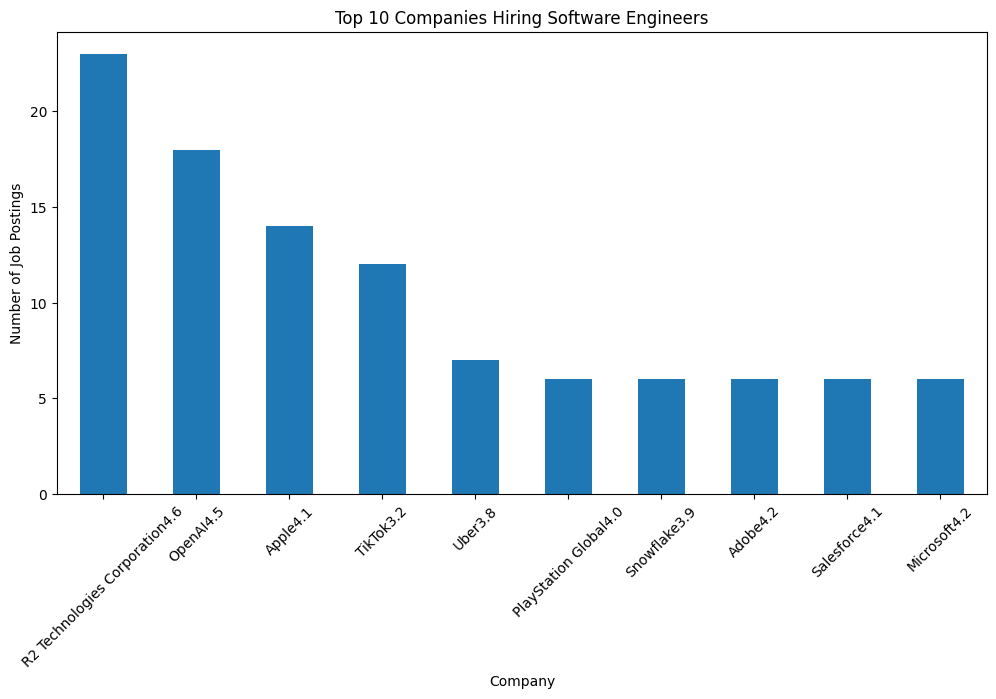

In [200]:
top_companies = df['Company'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_companies.plot(kind='bar')
plt.title('Top 10 Companies Hiring Software Engineers')
plt.xlabel('Company')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.show()

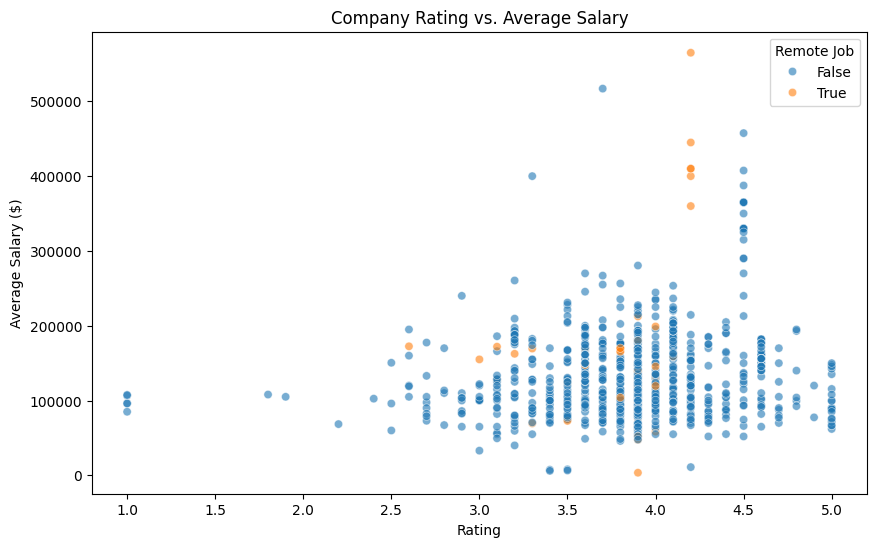

In [201]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='salary_avg', data=df, hue='Is_Remote', alpha=0.6)
plt.title('Company Rating vs. Average Salary')
plt.xlabel('Rating')
plt.ylabel('Average Salary ($)')
plt.legend(title='Remote Job')
plt.show()

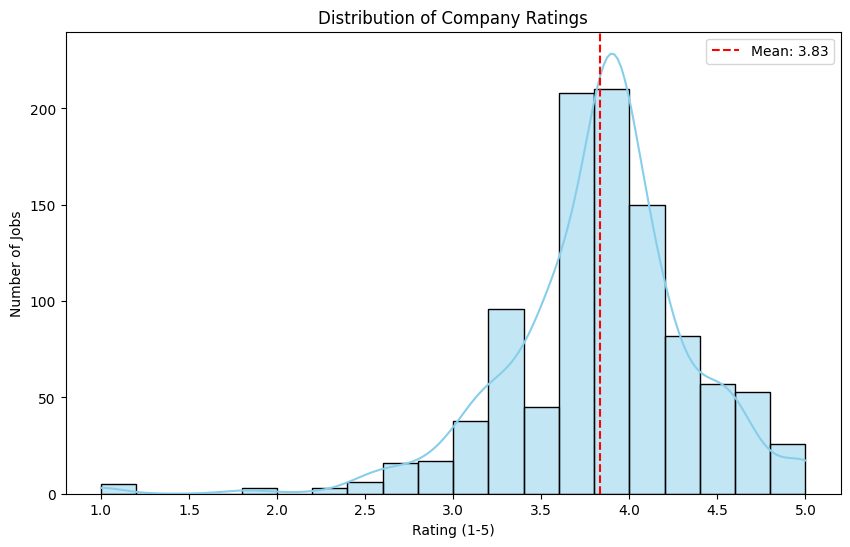

In [202]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Company Ratings')
plt.xlabel('Rating (1-5)')
plt.ylabel('Number of Jobs')
plt.axvline(df['Rating'].mean(), color='red', linestyle='--', label=f'Mean: {df["Rating"].mean():.2f}')
plt.legend()
plt.show()

### Remote Jobs Vs On-Site

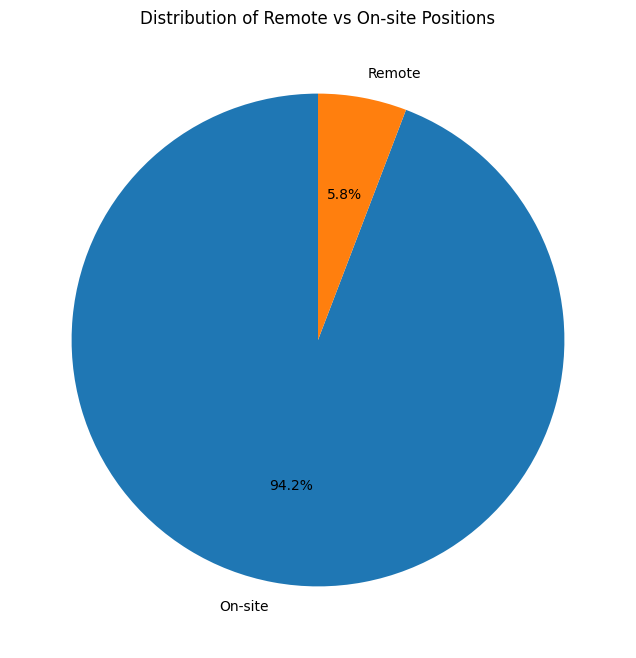

In [203]:
remote_counts = df['Is_Remote'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(remote_counts, labels=['On-site', 'Remote'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Remote vs On-site Positions')
plt.show()

### Top paying locations on avreage

In [204]:
from geopy.geocoders import Nominatim
import plotly.express as px

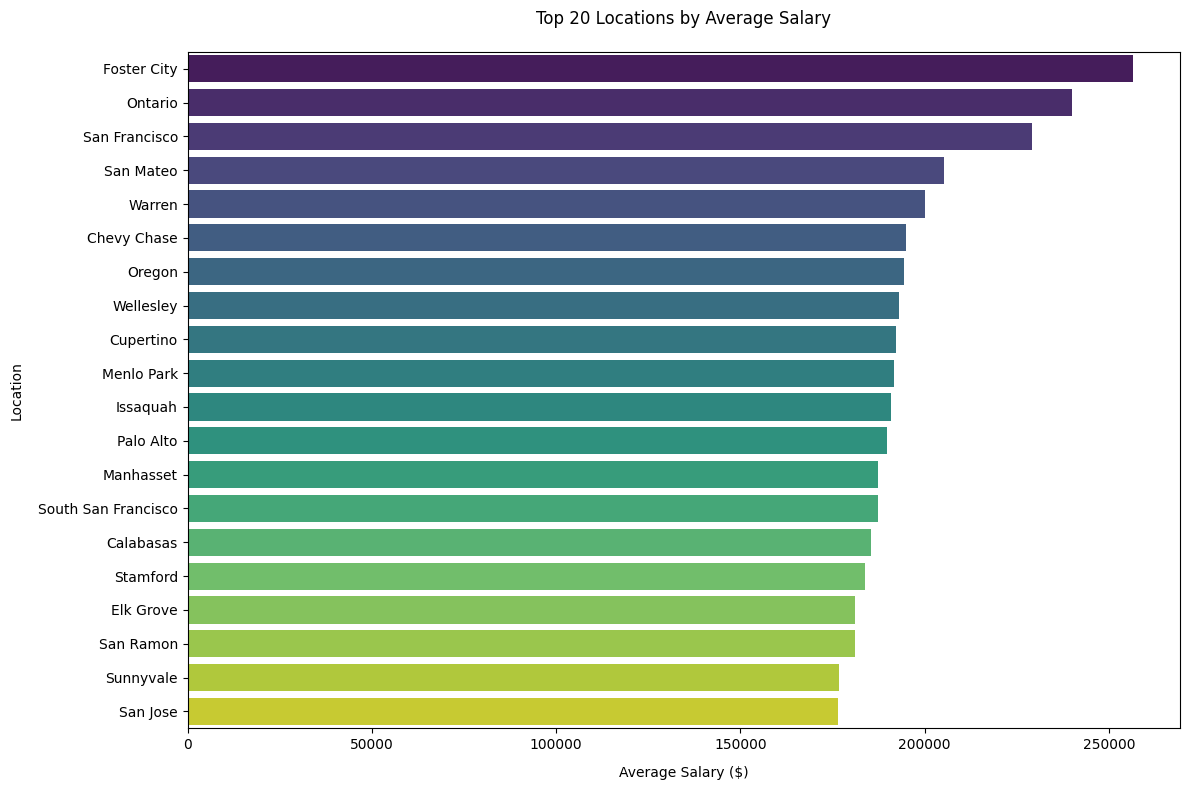

In [205]:
# Prepare the data
geo_df = df[df['clean_location'] != 'Remote'].groupby('clean_location')['salary_avg'].mean().reset_index()
geo_df = geo_df.sort_values('salary_avg', ascending=False).head(20)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='salary_avg', 
    y='clean_location', 
    hue='clean_location',  # Added to address warning
    data=geo_df, 
    palette='viridis',
    legend=False  # Added to prevent duplicate labels
)
plt.title('Top 20 Locations by Average Salary', pad=20)
plt.xlabel('Average Salary ($)', labelpad=10)
plt.ylabel('Location', labelpad=10)
plt.tight_layout()  # Improves spacing
plt.show()

### Average Salary For Each Job

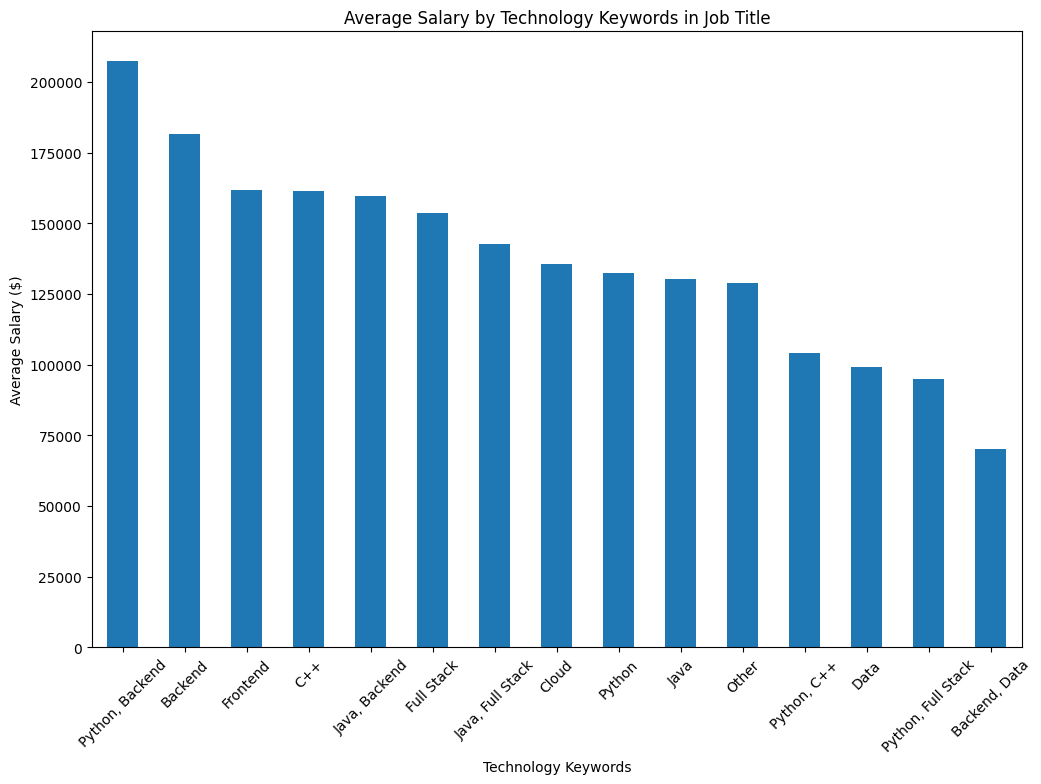

In [206]:
plt.figure(figsize=(12, 8))
tech_salaries.plot(kind='bar')
plt.title('Average Salary by Technology Keywords in Job Title')
plt.xlabel('Technology Keywords')
plt.ylabel('Average Salary ($)')
plt.xticks(rotation=45)
plt.show()